## Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
DIRECTORY = "/content/drive/MyDrive/Informatics/Sphere@mail.ru/IR/hw_01/"

## Задание

Построить графики распределения в спам и не спам множествах следующих признаков:

1	Количество слов на странице

2	Средняя длинна слова

3	Количество слов в заголовке страниц (слова в теге <html><head><title> Some text </title>)

4	Количество слов в анкорах ссылок (<html><body><a> Some text </a>)

5	Коэффициент сжатия

Нужно посчитать статистику минимум по трем признакам и обязательно сделать для 1-го и 2-го признаков

И отправить первое решение в соревнование https://www.kaggle.com/c/antispam-information-retrieval/
На основании одного из указанных выше признаков попытаться разделить мн-во, так чтобы score в соревновании был больше 0.55

При выполнении всех этих условия в течении семинара +1 балл к ДЗ

Описание ДЗ и правил выставления за него баллов в https://www.kaggle.com/c/antispam-information-retrieval/  
Сроки ДЗ уточнить у преподователя - обычно 2 недели

In [ ]:
from __future__ import division

import base64
import csv
import gzip
import zlib

import numpy as np
import pandas as pd
import time

from collections import namedtuple

from tqdm.notebook import tqdm

from sklearn.metrics import precision_recall_fscore_support

%matplotlib inline
import matplotlib.pyplot as plt

#### Logging

In [ ]:
TRACE_NUM = 1000
import logging
import importlib
importlib.reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%H:%M:%S')

def trace(items_num, trace_num=TRACE_NUM):
    if items_num % trace_num == 0: logging.info("Complete items %05d" % items_num)
        
def trace_worker(items_num, worker_id, trace_num=TRACE_NUM):
    if items_num % trace_num == 0: logging.info("Complete items %05d in worker_id %d" % (items_num, worker_id))

### Утилиты

#### Декораторы

In [ ]:
def to_utf8(text):
    if isinstance(text, unicode): text = text.encode('utf8')
    return text

def convert2unicode(f):
    def tmp(text):
        if not isinstance(text, unicode): text = text.decode('utf8')
        return f(text)
    return tmp

def convert2lower(f):
    def tmp(text):        
        return f(text.lower())
    return tmp

#P.S. Декораторы могут усложнять отладку, так что от них вполне можно отказаться и воспользоваться copy-paste

## Через фичи

#### Извлечение текста при помощи встроенных модулей

In [ ]:
from html.parser import HTMLParser
import re

class TextHTMLParser(HTMLParser):
    def __init__(self):
        HTMLParser.__init__(self)
        self._text = []
        self._anchors = []
        self._title = ""
        self._in_title = False
        self._in_anchor = False

        self._script_cnt = 0
        self._link_cnt = 0
        self._img_cnt = 0

    def handle_data(self, data):
        text = data.strip()
        if len(text) > 0:
            text = re.sub('[ \t\r\n]+', ' ', text)

            if self._in_title:
                self._title = text
            elif self._in_anchor:
                self._anchors.append(text + ' ')
            else:
                self._text.append(text + ' ')

    def handle_starttag(self, tag, attrs):
        if tag == 'p':
            self._text.append('\n\n')
        elif tag == 'br':
            self._text.append('\n')
        elif tag == 'title':
            self._in_title = True
        elif tag == 'a':
            self._in_anchor = True
        elif tag == 'script':
            self._script_cnt += 1
    
    def handle_endtag(self, tag):
        if tag == 'title':
            self._in_title = False
        if tag == 'a':
            self._in_anchor = False

    def handle_startendtag(self, tag, attrs):
        if tag == 'br':
            self._text.append('\n\n')
        elif tag == 'img':
            self._img_cnt += 1
        elif tag == 'link':
            self._link_cnt += 1

    def text(self):
        return ''.join(self._text).strip()
    
    def anchors(self):
        return ''.join(self._anchors).strip()
    
    def title(self):
        return self._title
    
    def images_cnt(self):
        return self._img_cnt
    
    def links_cnt(self):
        return self._link_cnt
    
    def scripts_cnt(self):
        return self._script_cnt

    def get_features(self, tokenizer=easy_tokenizer):
        return { 
            'title'   : tokenizer(self.title()),
            'text'    : tokenizer(self.text()),
            'anchors' : tokenizer(self.anchors()),
            'scripts_cnt' : self.scripts_cnt()
        }

#### Извлечение текста при помощи дополнительных библиотек

In [ ]:
# def html2text_bs(raw_html):
#     from bs4 import BeautifulSoup
#     """
#     Тут производится извлечения из html текста
#     """
#     soup = BeautifulSoup(raw_html, "html.parser")
#     [s.extract() for s in soup(['script', 'style'])]
#     return soup.get_text()

# def html2text_bs_visible(raw_html):
#     from bs4 import BeautifulSoup
#     """
#     Тут производится извлечения из html текста, который видим пользователю
#     """
#     soup = BeautifulSoup(raw_html, "html.parser")    
#     [s.extract() for s in soup(['style', 'script', '[document]', 'head', 'title'])]
#     return soup.get_text()

# def html2text_boilerpipe(raw_html):
#     import boilerpipe
#     """
#     еще одна библиотека очень хорошо извлекающая именно видимый пользователю текст,
#     но она завязана на java
#     """
#     pass

#### Методы для токенизации текста

In [ ]:
@convert2lower
def easy_tokenizer(text):
    word = ''
    for symbol in text:
        if symbol.isalnum(): word += symbol
        elif word:
            yield word
            word = ''
    if word: yield word

PYMORPHY_CACHE = {}
MORPH = None

#hint, чтобы установка pymorphy2 не была бы обязательной
def get_lemmatizer():
    import pymorphy2
    morph = MORPH
    if morph is None: morph = pymorphy2.MorphAnalyzer()
    return morph

def pymorphy_tokenizer(text):
    global PYMORPHY_CACHE
    for word in easy_tokenizer(text):
        word_hash = hash(word)
        if word_hash not in PYMORPHY_CACHE:
            PYMORPHY_CACHE[word_hash] = get_lemmatizer().parse(word)[0].normal_form            
        yield PYMORPHY_CACHE[word_hash]

In [ ]:
!pip install pymorphy2
MORPH = get_lemmatizer()

12:39:43 INFO:Loading dictionaries from /usr/local/lib/python3.7/dist-packages/pymorphy2_dicts_ru/data
12:39:43 INFO:format: 2.4, revision: 417127, updated: 2020-10-11T15:05:51.070345


#### Рассчет финальных метрик

In [ ]:
def safe_divide(a, b):
    if a == 0: return 0.0
    elif b == 0: return 0.0
    else: return a / b

In [ ]:
def calculate_metrics(y_true, y_pred_prob, threshold=0.5):    
    y_pred = np.array((y_pred_prob[:, 1] > threshold), dtype=int)
    precision, recall, fscore, _ = precision_recall_fscore_support(y_true, y_pred)

    return {
        'class_prec' : precision[1],
        'class_recall' : recall[1],
        'class_F1' : fscore[1],
        'not_class_prec' : precision[0],
        'not_class_recall' : recall[0],
        'not_class_F1' : fscore[0] 
    }

def arange(start, stop, step):
    cur_value = start
    while True:
        if cur_value > stop: break
        yield cur_value
        cur_value += step

def plot_results(classifier, X, y_true, min_threshold=0, max_threshold=1, step=0.1, trace=False):
    th = []
    y_p = []
    y_n = []
    names = ['class_prec', 'class_recall', 'class_F1', 'not_class_prec', 'not_class_recall', 'not_class_F1']
    y_pred_prob = classifier.predict_proba(X)
    best_fscore = -1
    best_threshold_fscore = -1
    best_diff = np.inf
    best_threshold_all = -1
    for threshold in arange(min_threshold, max_threshold, step):
        r = calculate_metrics(y_true, y_pred_prob, threshold)
        th.append(threshold)
        y_p.append((r['class_prec'], r['class_recall'], r['class_F1']))
        y_n.append((r['not_class_prec'], r['not_class_recall'], r['not_class_F1']))  
        fscore = (r['class_F1'] + r['not_class_F1'])/2
        if fscore > best_fscore:
            best_fscore = fscore
            best_threshold_fscore = threshold
        diff = 0
        for name1 in names:
            for name2 in names:
                diff += (r[name1] - r[name2]) ** 2
        if diff < best_diff:
            best_diff = diff
            best_threshold_all = threshold
        if trace: 
            print('threshold %s' % threshold)
            print('\t{}'.format(r))
            print('\t\tMacroF1Mesure %s' % ((r['class_F1'] + r['not_class_F1'])/2))
    plot_stats(th, y_p, "Class Result")
    plot_stats(th, y_n, "Not class Result")   
    print(f"Best threshold by f1 = {best_threshold_fscore}") 
    print(f"Best threshold by precision, recall, f1 = {best_threshold_all}") 
    return best_threshold_fscore, best_threshold_all


def plot_stats(x, y, title):
    plt.figure(figsize=(10, 5))

    prec, = plt.plot( x, 
                     [k[0] for k in y], "r", label='Precision', 
                     linewidth=1)
    accur, = plt.plot( x, 
                      [k[1] for k in y], "b", label='Recall',
                      linewidth=1)
    f1, =    plt.plot( x, 
                      [k[2] for k in y], "g", label='F1',
                      linewidth=1)
    plt.grid(True)
    plt.legend(handles=[prec, accur, f1])
    plt.title(title)
    plt.show()

#### Фичи

In [ ]:
def get_html_features(raw_html, Parser=TextHTMLParser, tokenizer=pymorphy_tokenizer):

    parser = Parser()
    parser.feed(raw_html)

    return parser.get_features(tokenizer)

In [ ]:
class Compression:
    def __init__(self, html_data, compressor=gzip):
        self.html_data = html_data
        self.compressed = compressor.compress(html_data.encode('utf-8'))        
    
    def get_compression_num(self):
        return len(self.compressed)

    def get_compression_level(self):        
        return safe_divide(len(self.html_data), len(self.compressed))

In [ ]:
def calc_features(url, html_data, get_keys=False):

    features = get_html_features(html_data)

    names = ['title', 'text', 'anchors']
    data = {}
    data_cnt = {}

    features['words_num'] = 0
    for name in names:
        data[name] = list(features[name])
        data_cnt[name] = len(data[name])
        del features[name]
        features['words_num'] += data_cnt[name]
        features[name + '_words_len'] = data_cnt[name]

    # Words

    letters_sum = 0
    data_lengths = {}
    for name in names:
        data_lengths[name] = []
        for word in data[name]:
            data_lengths[name].append(len(word))
        name_sum = np.sum(data_lengths[name])
        letters_sum += name_sum

    features['avg_word_len'] = letters_sum / features['words_num']

    # Unique words

    features['unique_words_num'] = 0
    data_unique = {}
    for name in names:
        data_unique[name] = set(data[name])
        features['unique_words_num'] += len(data_unique[name])

    # URL
    features['url_len'] = len(url)
    features['url_dots_cnt'] = url.count('.')
    features['url_slashs_cnt'] = url.count('/')

    # Compression
    gzip_compressor = Compression(html_data, gzip)
    zlib_compressor = Compression(html_data, zlib)

    features['gzip_compression_num'] = gzip_compressor.get_compression_num()
    features['gzip_compression_level']= gzip_compressor.get_compression_level()
    features['zlib_compression_num'] = zlib_compressor.get_compression_num()
    features['zlib_compression_level']= zlib_compressor.get_compression_level()
    
    if get_keys:
        return list(features.keys())
    return list(features.values())

In [ ]:
test_html_data = u'''
<html>
<title> Заголовок Ololo заголовки </title>
спам 1 2 3
</html>
'''
test_url = 'http://ololo'
test_features = calc_features(test_url, test_html_data)
print(test_features)

feature_to_idx = calc_features(test_url, test_html_data, get_keys=True)

[0, 0, 0, 7, 3, 4, 0, 4.285714285714286, 6, 12, 0, 2, 91, 0.7692307692307693, 79, 0.8860759493670886]


In [ ]:
feature_to_idx

['images_cnt',
 'links_cnt',
 'scripts_cnt',
 'words_num',
 'title_words_len',
 'text_words_len',
 'anchors_words_len',
 'avg_word_len',
 'unique_words_num',
 'url_len',
 'url_dots_cnt',
 'url_slashs_cnt',
 'gzip_compression_num',
 'gzip_compression_level',
 'zlib_compression_num',
 'zlib_compression_level']

#### Функции для загрузки данных

In [ ]:
from multiprocessing import Process, Queue

DocItem = namedtuple('DocItem', ['doc_id', 'is_spam', 'url', 'features'])

WORKER_NUM = 2

# def load_csv(input_file_name, calc_features_f):    
#     """
#     Загружаем данные и извлекаем на лету признаки
#     Сам контент не сохраняется, чтобы уменьшить потребление памяти - чтобы
#     можно было запускать даже на ноутбуках в классе
#     """
#     global LAST_HTML
#     with gzip.open(input_file_name, mode='rt', encoding='utf8') if input_file_name.endswith('gz') else open(input_file_name, mode='rt', encoding='utf8')  as input_file:            
#         headers = input_file.readline()
        
#         for i, line in enumerate(input_file):
#             trace(i)
#             parts = line.strip().split('\t')
#             url_id = int(parts[0])                                        
#             mark = bool(int(parts[1]))                    
#             url = parts[2]
#             pageInb64 = parts[3]
#             html_data = base64.b64decode(pageInb64)
#             try:
#                 html_data = html_data.decode('utf8')
#             except:
#                 html_data = html_data.decode('latin1')
#             features = calc_features_f(url, html_data)            
#             yield DocItem(url_id, mark, url, features)            
                
#         trace(i, 1)  
        
def load_csv_worker(input_file_name, calc_features_f, worker_id, res_queue):    
    with gzip.open(input_file_name,  mode='rt', encoding='utf8') if input_file_name.endswith('gz') else open(input_file_name, mode='rt', encoding='utf8')  as input_file:
        headers = input_file.readline()
        
        for i, line in enumerate(input_file):
            trace_worker(i, worker_id)
            if i % WORKER_NUM != worker_id: continue
            parts = line.strip().split('\t')
            url_id = int(parts[0])                                        
            mark = bool(int(parts[1]))                    
            url = parts[2]
            pageInb64 = parts[3]
            html_data = base64.b64decode(pageInb64)
            try:
                html_data = html_data.decode('utf8')
            except:
                html_data = html_data.decode('latin1')
            features = calc_features_f(url, html_data)
            res_queue.put(DocItem(url_id, mark, url, features))
                
        trace_worker(i, worker_id, 1)  
    res_queue.put(None)
        
def load_csv_multiprocess(input_file_name, calc_features_f):
    processes = []
    res_queue = Queue()    
    for i in range(WORKER_NUM):
        process = Process(target=load_csv_worker, args=(input_file_name, calc_features_f, i, res_queue))
        processes.append(process)
        process.start()
    
    complete_workers = 0
    while complete_workers != WORKER_NUM:
        item = res_queue.get()
        if item is None:
            complete_workers += 1
        else:
            yield item
        
    for process in processes: process.join()

#### Функции для анализа данных

In [ ]:
def hist_plot(feature, bins=None):
    feature_idx = feature_to_idx.index(feature)
    is_spam_data = [doc.features[feature_idx] for doc in train_docs if doc[1] == True]
    not_spam_data = [doc.features[feature_idx] for doc in train_docs if doc[1] == False]
    plt.hist(is_spam_data, bins=bins, color='red', density=True, alpha=0.7, label='spam')
    plt.hist(not_spam_data, bins=bins, color='blue', density=True, alpha=0.7, label='not_spam')
    plt.title(feature)
    plt.legend()
    plt.show()

### Обработка данных

#### Загрузка данных

** Обрабатываем входной файл **
<br>
Формат - поля разделенные табуляциями
<br>
0 - идентификатор документа
<br>
1 - метка класса 0 - не спам, 1 - спам
<br>
2 - урл документа
<br>
3 - документ в кодировке base64

Выходной формат - массив кортежей вида
(doc_id, is_spam, url, html_data)

In [ ]:
%%time

TRAIN_DATA_FILE  = DIRECTORY + 'kaggle_train_data_tab.csv'

train_docs = list(load_csv_multiprocess(TRAIN_DATA_FILE, calc_features))

17:58:35 INFO:Complete items 00000 in worker_id 0
17:58:35 INFO:Complete items 00000 in worker_id 1
17:59:38 INFO:Complete items 01000 in worker_id 1
17:59:40 INFO:Complete items 01000 in worker_id 0
18:00:14 INFO:Complete items 02000 in worker_id 1
18:00:16 INFO:Complete items 02000 in worker_id 0
18:00:49 INFO:Complete items 03000 in worker_id 1
18:00:57 INFO:Complete items 03000 in worker_id 0
18:01:26 INFO:Complete items 04000 in worker_id 1
18:01:34 INFO:Complete items 04000 in worker_id 0
18:02:06 INFO:Complete items 05000 in worker_id 1
18:02:06 INFO:Complete items 05000 in worker_id 0
18:02:32 INFO:Complete items 06000 in worker_id 0
18:02:34 INFO:Complete items 06000 in worker_id 1
18:03:03 INFO:Complete items 07000 in worker_id 0
18:03:03 INFO:Complete items 07043 in worker_id 0
18:03:13 INFO:Complete items 07000 in worker_id 1
18:03:14 INFO:Complete items 07043 in worker_id 1


CPU times: user 2.43 s, sys: 411 ms, total: 2.84 s
Wall time: 4min 38s


In [ ]:
len(train_docs)

7044

In [ ]:
X_train = []
y_train = []
for doc_num, doc in enumerate(train_docs):
    X_train.append(doc.features)
    y_train.append(doc.is_spam)
X_train = np.array(X_train)
y_train = np.array(y_train)

In [ ]:
%%time

TEST_DATA_FILE  = DIRECTORY + 'kaggle_test_data_tab.csv'

test_docs = list(load_csv_multiprocess(TEST_DATA_FILE, calc_features))

In [ ]:
len(test_docs)

In [ ]:
X_test = []
for doc_num, doc in enumerate(test_docs):
    X_test.append(doc.features)
X_test = np.array(X_test)
test_docs_id = [i[0] for i in test_docs]

#### Анализ данных

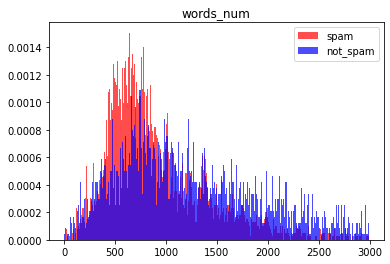

In [ ]:
hist_plot('words_num', bins=range(0,3000,10))

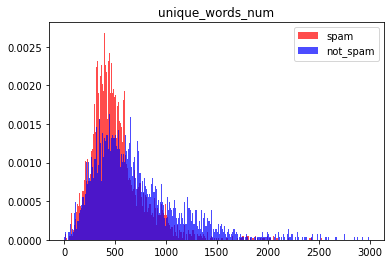

In [ ]:
hist_plot('unique_words_num', bins=range(0,3000,10))

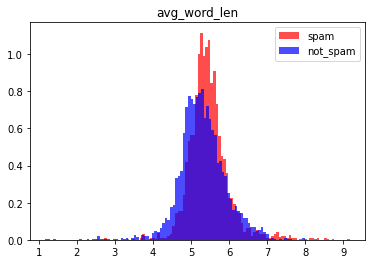

In [ ]:
hist_plot('avg_word_len', bins=100)

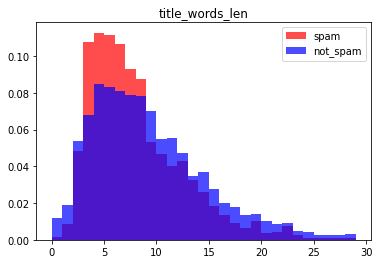

In [ ]:
hist_plot('title_words_len', bins=range(0, 30, 1))

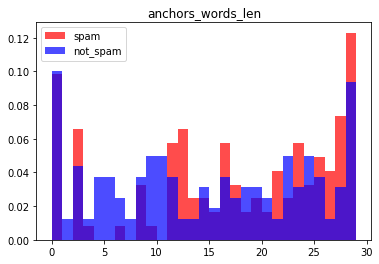

In [ ]:
hist_plot('anchors_words_len', bins=range(0, 30, 1))

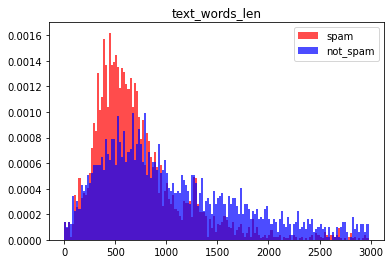

In [ ]:
hist_plot('text_words_len', bins=range(0, 3000, 20))

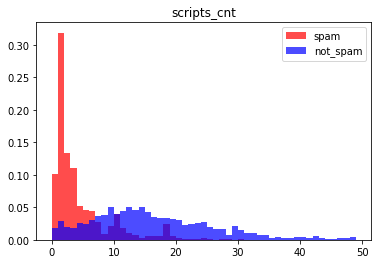

In [ ]:
hist_plot('scripts_cnt', bins=range(0, 50, 1))

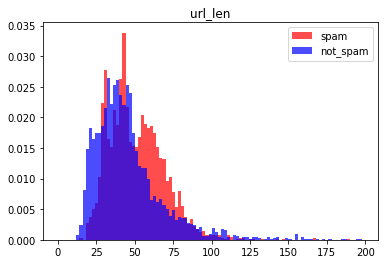

In [ ]:
hist_plot('url_len', bins=range(0, 200, 2))

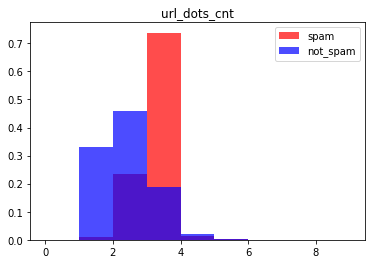

In [ ]:
hist_plot('url_dots_cnt', bins=range(0, 10, 1))

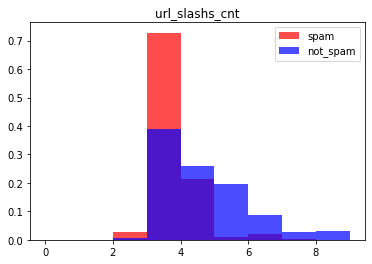

In [ ]:
hist_plot('url_slashs_cnt', bins=range(0, 10, 1))

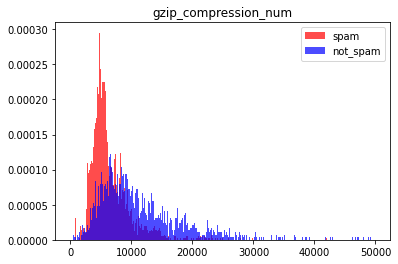

In [ ]:
hist_plot('gzip_compression_num', bins=range(0, 50000, 100))

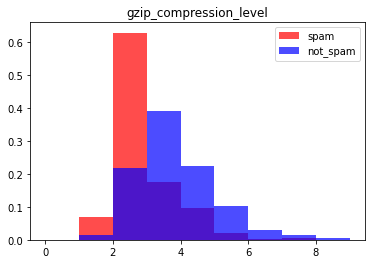

In [ ]:
hist_plot('gzip_compression_level', bins=range(0, 10, 1))

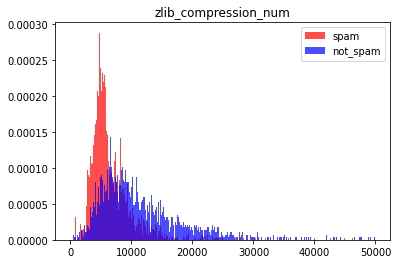

In [ ]:
hist_plot('zlib_compression_num', bins=range(0, 50000, 100))

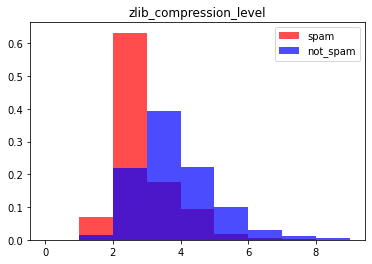

In [ ]:
hist_plot('zlib_compression_level', bins=range(0, 10, 1))

### Модель

#### Функции

In [ ]:
from copy import deepcopy
from itertools import product
from sklearn.model_selection import KFold

In [ ]:
def my_cv_score(clf, X, y, n_splits=3):
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    scores = []
    for train_index, test_index in cv.split(X):
        try:
            X_train, X_test = X[train_index].toarray(), X[test_index].toarray()
        except AttributeError:
            X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        metrics = calculate_metrics(y, clf.predict_proba(X))
        score = (metrics['class_F1'] + metrics['not_class_F1']) / 2
        scores.append(score)

    scores = np.asarray(scores)
    return scores.mean()

In [ ]:
def search_parametrs(clf, parametrs, X_train, y_train, print_scores=False):
    best_model = None
    best_score = 0
    best_params = None
    model = deepcopy(clf)
    keys = parametrs.keys()
    for cur_param in tqdm(list(product(*parametrs.values()))):
        params_to_set = dict()
        for i, key in enumerate(keys):
            params_to_set[key] = cur_param[i]
        model.set_params(**params_to_set)
        model.fit(X_train, y_train)
        score = my_cv_score(model, X_train, y_train)
        if print_scores:
            print(f'{str(params_to_set)} - SCORE: {score}')
        if score > best_score:
            best_score = score
            best_model = deepcopy(model)
            best_params = params_to_set
    print(best_params)
    print('F1-Score: ', best_score)
    # print(best_model)
    return best_model

In [ ]:
def boosting_search(clf, model_name, X_train, y_train):
    parametrs = {
        'learning_rate': np.linspace(1e-2, 1, 100),
    }
    clf = search_parametrs(clf, parametrs, X_train, y_train, print_scores=False)

    parametrs = {
        'max_depth': np.linspace(1, 15, 6, dtype=int),
        'scale_pos_weight': np.linspace(0.2, 3, 5),
        'max_leaves': np.linspace(0, 10, 5, dtype=int),
    }
    if model_name != 'CBC':
        parametrs['min_child_weight'] = np.linspace(0, 100, 5)
    clf = search_parametrs(clf, parametrs, X_train, y_train)
    cur_scale = clf.get_param('scale_pos_weight') if model_name == 'CBC' else clf.scale_pos_weight

    parametrs = {
        'scale_pos_weight': np.linspace(cur_scale - 0.1, cur_scale + 0.1, 21),
    }
    clf = search_parametrs(clf, parametrs, X_train, y_train, print_scores=True)

    parametrs = {
        'scale_pos_weight': np.linspace(cur_scale - 0.01, cur_scale + 0.01, 21),
    }
    clf = search_parametrs(clf, parametrs, X_train, y_train, print_scores=True)

    cur_scale = clf.get_param('scale_pos_weight') if model_name == 'CBC' else clf.scale_pos_weight
    parametrs = {
        'scale_pos_weight': np.linspace(cur_scale - 0.001, cur_scale + 0.001, 21),
    }
    clf = search_parametrs(clf, parametrs, X_train, y_train, print_scores=True)

    parametrs = {
        'subsample': np.linspace(1e-2, 1, 100),
    }
    clf = search_parametrs(clf, parametrs, X_train, y_train)

    parametrs = {
        'reg_lambda': np.linspace(0, 5, 11),
    }
    if model_name != 'CBC':
        parametrs['reg_alpha'] = np.linspace(0, 5, 11)
    clf = search_parametrs(clf, parametrs, X_train, y_train, print_scores=False)

    cur_lr = clf.get_param('learning_rate') if model_name == 'CBC' else clf.learning_rate
    parametrs = {
        'learning_rate': np.linspace(1e-5, cur_lr, 10),
        'n_estimators': [25, 50, 100]
    }
    clf = search_parametrs(clf, parametrs, X_train, y_train, print_scores=True)

    return clf

#### Поиск параметров

In [ ]:
models = {
    'XGB': {},
    'LGB': {}
}

##### XGB

In [ ]:
from xgboost import XGBClassifier

In [ ]:
name = 'XGB'

In [ ]:
%%time

clf = XGBClassifier(random_state=77, n_estimators=25)
clf.fit(X_train, y_train)

clf = boosting_search(clf, name, X_train, y_train)

In [ ]:
th_f1, th_prf1 = plot_results(clf, X_valid, y_valid, step=0.01)

In [ ]:
models[name]['model'] = clf
models[name]['th_f1'] = th_f1
models[name]['th_prf1'] = th_prf1

##### LGBM

In [ ]:
from lightgbm import LGBMClassifier

In [ ]:
name = 'LGB'

In [ ]:
%%time

clf = LGBMClassifier(random_state=77, n_estimators=25)
clf.fit(X_train, y_train)

clf = boosting_search(clf, name, X_train, y_train)

In [ ]:
th_f1, th_prf1 = plot_results(clf, X_valid, y_valid, step=0.01)

In [ ]:
models[name]['model'] = clf
models[name]['th_f1'] = th_f1
models[name]['th_prf1'] = th_prf1

#### Предсказание

In [ ]:
name = 'LGB'
threshold = 0.5

clf = models[name]['model']

In [ ]:
pred = np.array((clf.predict_proba(X_test)[:, 1] > threshold), dtype=int)

In [ ]:
name = str(time.strftime("%Y.%m.%d-%X")) + "_predict.csv"
result = np.array(list(zip(test_docs_id, pred)))
df = pd.DataFrame(result, columns = ['Id', 'Prediction'])
df.to_csv(name, index=False)
print(name)
print(clf)
print(f"th = {threshold}")

Лучший результат: 

`LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,               importance_type='split', learning_rate=0.18667333333333339,               max_depth=15, max_leaves=0, min_child_samples=20,               min_child_weight=0.0, min_split_gain=0.0, n_estimators=100,               n_jobs=-1, num_leaves=31, objective=None, random_state=77,               reg_alpha=0.0, reg_lambda=0.0,               scale_pos_weight=0.8972999999999999, silent=True, subsample=0.01,               subsample_for_bin=200000, subsample_freq=0)`

th = 0.5

Score: 0.93734

## TFIDF

### Функции для загрузки данных

In [ ]:
from multiprocessing import Process, Queue

DocItemText = namedtuple('DocItemText', ['doc_id', 'is_spam', 'text'])

WORKER_NUM = 2
        
def load_csv_text_worker(input_file_name, worker_id, res_queue):    
    with gzip.open(input_file_name,  mode='rt', encoding='utf8') if input_file_name.endswith('gz') else open(input_file_name, mode='rt', encoding='utf8')  as input_file:
        headers = input_file.readline()
        
        for i, line in enumerate(input_file):
            trace_worker(i, worker_id)
            if i % WORKER_NUM != worker_id: continue
            parts = line.strip().split('\t')
            url_id = int(parts[0])                                        
            mark = bool(int(parts[1]))                    
            url = parts[2]
            pageInb64 = parts[3]
            html_data = base64.b64decode(pageInb64)
            try:
                html_data = html_data.decode('utf8')
            except:
                html_data = html_data.decode('latin1')
            res_queue.put(DocItemText(url_id, mark, html_data))
                
        trace_worker(i, worker_id, 1)  
    res_queue.put(None)
        
def load_csv_text_multiprocess(input_file_name):
    processes = []
    res_queue = Queue()    
    for i in range(WORKER_NUM):
        process = Process(target=load_csv_text_worker, args=(input_file_name, i, res_queue))
        processes.append(process)
        process.start()
    
    complete_workers = 0
    while complete_workers != WORKER_NUM:
        item = res_queue.get()
        if item is None:
            complete_workers += 1
        else:
            yield item
        
    for process in processes: process.join()

### Токенайзер

In [ ]:
@convert2lower
def easy_tokenizer(text):
    word = ''
    for symbol in text:
        if symbol.isalnum(): word += symbol
        elif word:
            yield word
            word = ''
    if word: yield word

PYMORPHY_CACHE = {}
MORPH = None

#hint, чтобы установка pymorphy2 не была бы обязательной
def get_lemmatizer():
    import pymorphy2
    morph = MORPH
    if morph is None: morph = pymorphy2.MorphAnalyzer()
    return morph

def pymorphy_tokenizer(text):
    global PYMORPHY_CACHE
    for word in easy_tokenizer(text):
        word_hash = hash(word)
        if word_hash not in PYMORPHY_CACHE:
            PYMORPHY_CACHE[word_hash] = get_lemmatizer().parse(word)[0].normal_form            
        yield PYMORPHY_CACHE[word_hash]

In [ ]:
!pip install pymorphy2
MORPH = get_lemmatizer()

17:13:02 INFO:Loading dictionaries from /usr/local/lib/python3.7/dist-packages/pymorphy2_dicts_ru/data
17:13:02 INFO:format: 2.4, revision: 417127, updated: 2020-10-11T15:05:51.070345


### Загрузка данных

In [ ]:
%%time

TRAIN_DATA_FILE  = DIRECTORY + 'kaggle_train_data_tab.csv'
TEST_DATA_FILE  = DIRECTORY + 'kaggle_test_data_tab.csv'

train_docs = list(load_csv_text_multiprocess(TRAIN_DATA_FILE))
test_docs = list(load_csv_text_multiprocess(TEST_DATA_FILE))

test_docs_id = [i[0] for i in test_docs]

17:13:02 INFO:Complete items 00000 in worker_id 0
17:13:02 INFO:Complete items 00000 in worker_id 1
17:13:04 INFO:Complete items 01000 in worker_id 1
17:13:04 INFO:Complete items 01000 in worker_id 0
17:13:05 INFO:Complete items 02000 in worker_id 0
17:13:05 INFO:Complete items 02000 in worker_id 1
17:13:06 INFO:Complete items 03000 in worker_id 1
17:13:06 INFO:Complete items 03000 in worker_id 0
17:13:07 INFO:Complete items 04000 in worker_id 0
17:13:07 INFO:Complete items 04000 in worker_id 1
17:13:08 INFO:Complete items 05000 in worker_id 1
17:13:08 INFO:Complete items 05000 in worker_id 0
17:13:09 INFO:Complete items 06000 in worker_id 0
17:13:09 INFO:Complete items 06000 in worker_id 1
17:13:10 INFO:Complete items 07000 in worker_id 0
17:13:10 INFO:Complete items 07043 in worker_id 0
17:13:10 INFO:Complete items 07000 in worker_id 1
17:13:10 INFO:Complete items 07043 in worker_id 1
17:13:11 INFO:Complete items 00000 in worker_id 0
17:13:11 INFO:Complete items 00000 in worker_id 1


CPU times: user 4.31 s, sys: 3.65 s, total: 7.96 s
Wall time: 28.9 s


In [ ]:
def get_text(docs):
    return list(map(lambda doc: doc.text, tqdm(docs)))

In [ ]:
def get_text_token(docs):
    return list(map(lambda doc: list(pymorphy_tokenizer(doc.text)), tqdm(docs)))

get_text_token не дал прирост, но тратит время на токенизацию

In [ ]:
%%time

train_text = get_text(train_docs)
test_text = get_text(test_docs)


CPU times: user 125 ms, sys: 12.5 ms, total: 138 ms
Wall time: 152 ms


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(decode_error='ignore')

In [ ]:
%%time
X_train = vectorizer.fit_transform(tqdm(train_text))
y_train = np.array(list(map(lambda doc: doc.is_spam, tqdm(train_docs))))


CPU times: user 41.8 s, sys: 1.01 s, total: 42.8 s
Wall time: 43.1 s


In [ ]:
%%time
X_test = vectorizer.transform(tqdm(test_text))


CPU times: user 1min 37s, sys: 1.38 s, total: 1min 38s
Wall time: 1min 39s


In [ ]:
X_train.shape, y_train.shape, X_test.shape

((7044, 1013073), (7044,), (16039, 1013073))

### Модель

#### Функции

In [ ]:
from copy import deepcopy
from itertools import product
from sklearn.model_selection import KFold

In [ ]:
def calculate_metrics(y_true, y_pred_prob=None, y_pred=None, threshold=0.5):   
    if y_pred_prob is not None:
        y_pred = np.array((y_pred_prob[:, 1] > threshold), dtype=int)
    precision, recall, fscore, _ = precision_recall_fscore_support(y_true, y_pred)

    return {
        'class_prec' : precision[1],
        'class_recall' : recall[1],
        'class_F1' : fscore[1],
        'not_class_prec' : precision[0],
        'not_class_recall' : recall[0],
        'not_class_F1' : fscore[0] 
    }

In [ ]:
def my_cv_score(clf, X, y, n_splits=3):
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    scores = []
    for train_index, test_index in cv.split(X):
        try:
            X_train, X_test = X[train_index].toarray(), X[test_index].toarray()
        except AttributeError:
            X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        metrics = calculate_metrics(y, y_pred=clf.predict(X))
        score = (metrics['class_F1'] + metrics['not_class_F1']) / 2
        scores.append(score)

    scores = np.asarray(scores)
    return scores.mean()

In [ ]:
def search_parametrs(clf, parametrs, X_train, y_train, print_scores=False):
    best_model = None
    best_score = 0
    best_params = None
    model = deepcopy(clf)
    keys = parametrs.keys()
    for cur_param in tqdm(list(product(*parametrs.values()))):
        params_to_set = dict()
        for i, key in enumerate(keys):
            params_to_set[key] = cur_param[i]
        model.set_params(**params_to_set)
        model.fit(X_train, y_train)
        metrics = calculate_metrics(y_train, y_pred=model.predict(X_train))
        score = (metrics['class_F1'] + metrics['not_class_F1']) / 2
        # score = my_cv_score(model, X_train, y_train)
        if print_scores:
            print(f'{str(params_to_set)} - SCORE: {score}')
        if score > best_score:
            best_score = score
            best_model = deepcopy(model)
            best_params = params_to_set
    print(best_params)
    print('F1-Score: ', best_score)
    # print(best_model)
    return best_model

In [ ]:
def search_by_name(model_name):
    global models_data
    if model_name == 'KNC':
        clf = models_data[model_name]['clf']()
    else:
        clf = models_data[model_name]['clf'](random_state=77)
    clf.fit(X_train, y_train)

    metrics = calculate_metrics(y_train, y_pred=clf.predict(X_train))
    score = (metrics['class_F1'] + metrics['not_class_F1']) / 2

    print(f'{model_name}: F1-score = {score}')

    models_data[model_name]['model'] = clf

    make_prediction(model_name)

In [ ]:
def make_prediction(model_name):
    clf = models_data[model_name]['model']
    pred = np.array(clf.predict(X_test))

    name = str(time.strftime("%Y.%m.%d-%X")) + "_" + model_name + "_predict.csv"
    result = np.array(list(zip(test_docs_id, pred)))
    df = pd.DataFrame(result, columns = ['Id', 'Prediction'])
    df.to_csv(name, index=False)
    print(name)
    print(clf)

#### Поиск параметров

In [ ]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier

models_data = {
    # 'XGB': {
    #     'clf': XGBClassifier
    # },
    # 'LGB': {
    #     'clf': LGBMClassifier 
    # },
    'SGD': {
        'clf': SGDClassifier
    },
    # 'MLP': {
    #     'clf': MLPClassifier
    # },
}

##### XGB

In [ ]:
# name = 'XGB'

In [ ]:
# %%time

# search_by_name(name)

XGB: F1-score = 0.9874519056414723
CPU times: user 2min 49s, sys: 796 ms, total: 2min 49s
Wall time: 2min 49s


##### LGBM

In [ ]:
# name = 'LGB'

In [ ]:
# %%time

# search_by_name(name)

LGB: F1-score = 1.0
CPU times: user 2min 21s, sys: 795 ms, total: 2min 21s
Wall time: 2min 21s


##### MLP

In [ ]:
# %%time
# model_name = 'MLP'

# search_by_name(model_name)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:573: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


MLP: F1-score = 0.9959149655355249
CPU times: user 5min 59s, sys: 25.2 s, total: 6min 24s
Wall time: 6min


##### SGD

In [ ]:
%%time

model_name = 'SGD'
parametrs = {
    'loss': ['log', 'modified_huber', 'huber'],
    'penalty': ['elasticnet'],
    'l1_ratio': np.linspace(0, 1, 5),
    'alpha': np.linspace(1e-4, 1e-1, 5),
    # 'max_iter': np.linspace(1e2, 1e4, 5, dtype=int)
}

models_data[model_name]['model'] = search_parametrs(models_data[model_name]['clf'](random_state=77), parametrs, X_train, y_train)

make_prediction(model_name)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



{'loss': 'modified_huber', 'penalty': 'elasticnet', 'l1_ratio': 0.0, 'alpha': 0.0001, 'max_iter': 100}
F1-Score:  0.999270072614511
CPU times: user 7min 52s, sys: 37.1 s, total: 8min 29s
Wall time: 7min 45s


Лучший результат:

```
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.0, learning_rate='optimal', loss='modified_huber',
              max_iter=1000, n_iter_no_change=5, n_jobs=None,
              penalty='elasticnet', power_t=0.5, random_state=77, shuffle=True,
              tol=0.001, validation_fraction=0.1, verbose=0, warm_start=False)
```

Score: 0.97681

Бустинг учится дольше и дает результат хуже